In [183]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import (YEARLY, DateFormatter,
                              rrulewrapper, RRuleLocator, drange)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense

from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler


In [184]:
#!wget https://raw.githubusercontent.com/JasonMorris1/CSE151_Tesla_Stock_Prediction/main/tsla_2014_2023.csv
df = pd.read_csv('tsla_2014_2023.csv')
df['date']=pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df = df.drop(columns=['open', 'high', 'low']) # not sure why we do this
#note I didn't drop other columns
df.head()

window  = 40



In [185]:

#df = df.drop(columns=['sma_50', 'sma_100', 'rsi_7', 'ema_50', 'atr_7'], axis=1)

scaler = MinMaxScaler()


df_temp = df.drop(['date'], axis = 1)

df_scale = scaler.fit_transform(df_temp)

df_scaled = pd.DataFrame(df_scale, columns=df_temp.columns)

df_scaled.drop(['year'], axis = 1)
df_scaled['year'] = df['year']


df_scaled['date'] = df['date']
df = df_scaled


df_train1=df[(df.year<2022) & (df.year>2019)]
df_test1=df[(df.year >=2022)]





x_date = df['date']
df_train = df_train1.drop(['date','year','next_day_close'],axis=1)
df_test = df_test1.drop(['date','year','next_day_close'],axis=1)


df_train.head()

#df_train = df_train.drop(['rsi_7', 'rsi_14', 'cci_7', 'sma_50', 'ema_50', 'sma_100', 'ema_100', 'macd', 'bollinger', 'TrueRange', 'atr_7', 'atr_14', 'cci_14', 'volume'], axis = 1)
#df_test = df_test.drop(['rsi_7', 'rsi_14', 'cci_7', 'sma_50', 'ema_50', 'sma_100', 'ema_100', 'macd', 'bollinger', 'TrueRange', 'atr_7', 'atr_14', 'cci_14', 'volume'], axis = 1)




,close,volume,rsi_7,rsi_14,cci_7,cci_14,sma_50,ema_50,sma_100,ema_100,macd,bollinger,TrueRange,atr_7,atr_14
1510,0.048404,0.146505,0.755192,0.762071,0.620249,0.583335,0.039886,0.041084,0.028245,0.036739,0.425372,0.043739,0.012720,0.027154,0.023047
1511,0.050526,0.283418,0.812970,0.799436,0.836385,0.651220,0.040603,0.041786,0.028690,0.037274,0.426315,0.044747,0.026708,0.031080,0.025427
1512,0.051945,0.156481,0.843467,0.821260,0.771803,0.658383,0.041357,0.042528,0.029140,0.037835,0.427459,0.045859,0.011724,0.029663,0.025056
1513,0.054860,0.285138,0.890264,0.859076,0.786992,0.722024,0.042005,0.043378,0.029659,0.038459,0.429501,0.047080,0.022218,0.031798,0.026519
1514,0.058700,0.505328,0.928877,0.896748,0.805556,0.772126,0.042633,0.044375,0.030235,0.039169,0.432691,0.048480,0.034729,0.037620,0.030032


In [186]:
X_train = []
y_train = []


df_trainnp = df_train.to_numpy()


for i in range(window, df_train.shape[0]):
    X_train.append(df_trainnp[i-window: i])
    y_train.append(df_trainnp[i, 0])

X_train = np.array(X_train)
y_train = np.array(y_train)

In [187]:
regressor = Sequential()

regressor.add(LSTM(units = 80, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 15)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 90, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 100, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.4))

regressor.add(LSTM(units = 120, activation = 'relu'))
regressor.add(Dropout(0.5))

regressor.add(Dense(units = 1))

c:\Users\jason\miniconda3\envs\pythonProject1\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [188]:
regressor.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_48 (LSTM)                  │ (None, 40, 80)         │        30,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 40, 80)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_49 (LSTM)                  │ (None, 40, 90)         │        61,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 40, 90)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_50 (LSTM)                  │ (None, 40, 100)        │        76,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 40, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_51 (LSTM)                  │ (None, 120)            │       106,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 274,881 (1.05 MB)

 Trainable params: 274,881 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

In [189]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [190]:
regressor.fit(X_train, y_train, epochs=30, batch_size = 64)
#regressor.save('newLtsm.keras')

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - loss: 0.1726
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - loss: 0.0335
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - loss: 0.0173
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - loss: 0.0185
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - loss: 0.0144
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - loss: 0.0148
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.0123
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 0.0104
Epoch 9/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - loss: 0.0105
Epoch 10/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - loss: 0.0099
Epoch 11/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 0.0088
Epoch 12/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - loss: 0.0090
Epoch 13/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - loss: 0.0089
Epoch 14/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - loss: 0.0080
Epoch 15/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 0.0095
Epoch 16/30
8/8 ━━━

In [191]:
past_data = df_train.tail(window)


dt = pd.concat([past_data, df_test], ignore_index=True)

In [192]:
data_test = dt.to_numpy()
print(data_test.shape)


(541, 15)


In [193]:
X_test = []
y_test = []

for i in range(window, data_test.shape[0]):
    X_test.append(data_test[i-window:i])
    y_test.append(data_test[i, 0])
    
    
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

print(y_test)

[0.97493432 0.93318034 0.88204238 0.86255886 0.83116232 0.85708485
 0.86230927 0.89710007 0.83498912 0.85000523 0.83411559 0.80511496
 0.80563074 0.76206321 0.75049956 0.74084931 0.75666408 0.66655908
 0.68090966 0.75609003 0.75153944 0.73025067 0.71817123 0.74494239
 0.73164828 0.74384425 0.75216337 0.72932725 0.6922653  0.70537638
 0.74420192 0.74500057 0.70586719 0.68975295 0.66026143 0.61243449
 0.64299086 0.65056129 0.70094225 0.69590078 0.70881216 0.67503632
 0.67420438 0.64616044 0.66264903 0.69140845 0.67421268 0.63848185
 0.61437287 0.64392258 0.6758183  0.70191555 0.73002606 0.74314544
 0.80372564 0.80799343 0.82031408 0.81758542 0.88513709 0.89156788
 0.88692574 0.87329065 0.87910572 0.92973627 0.88465459 0.84680236
 0.85636944 0.82993935 0.78870954 0.79787729 0.82734382 0.79625506
 0.81230274 0.83215231 0.78976609 0.81603807 0.81293498 0.80708662
 0.70592545 0.71015988 0.70683219 0.70121674 0.7279879  0.7332373
 0.76931757 0.70331317 0.69696563 0.63162683 0.64238353 0.58744

In [194]:
y_pred = regressor.predict(X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step


In [195]:
scale = 1/scaler.scale_[0]
print(scale)
y_pred = y_pred*scale
y_test = y_test*scale

400.680668


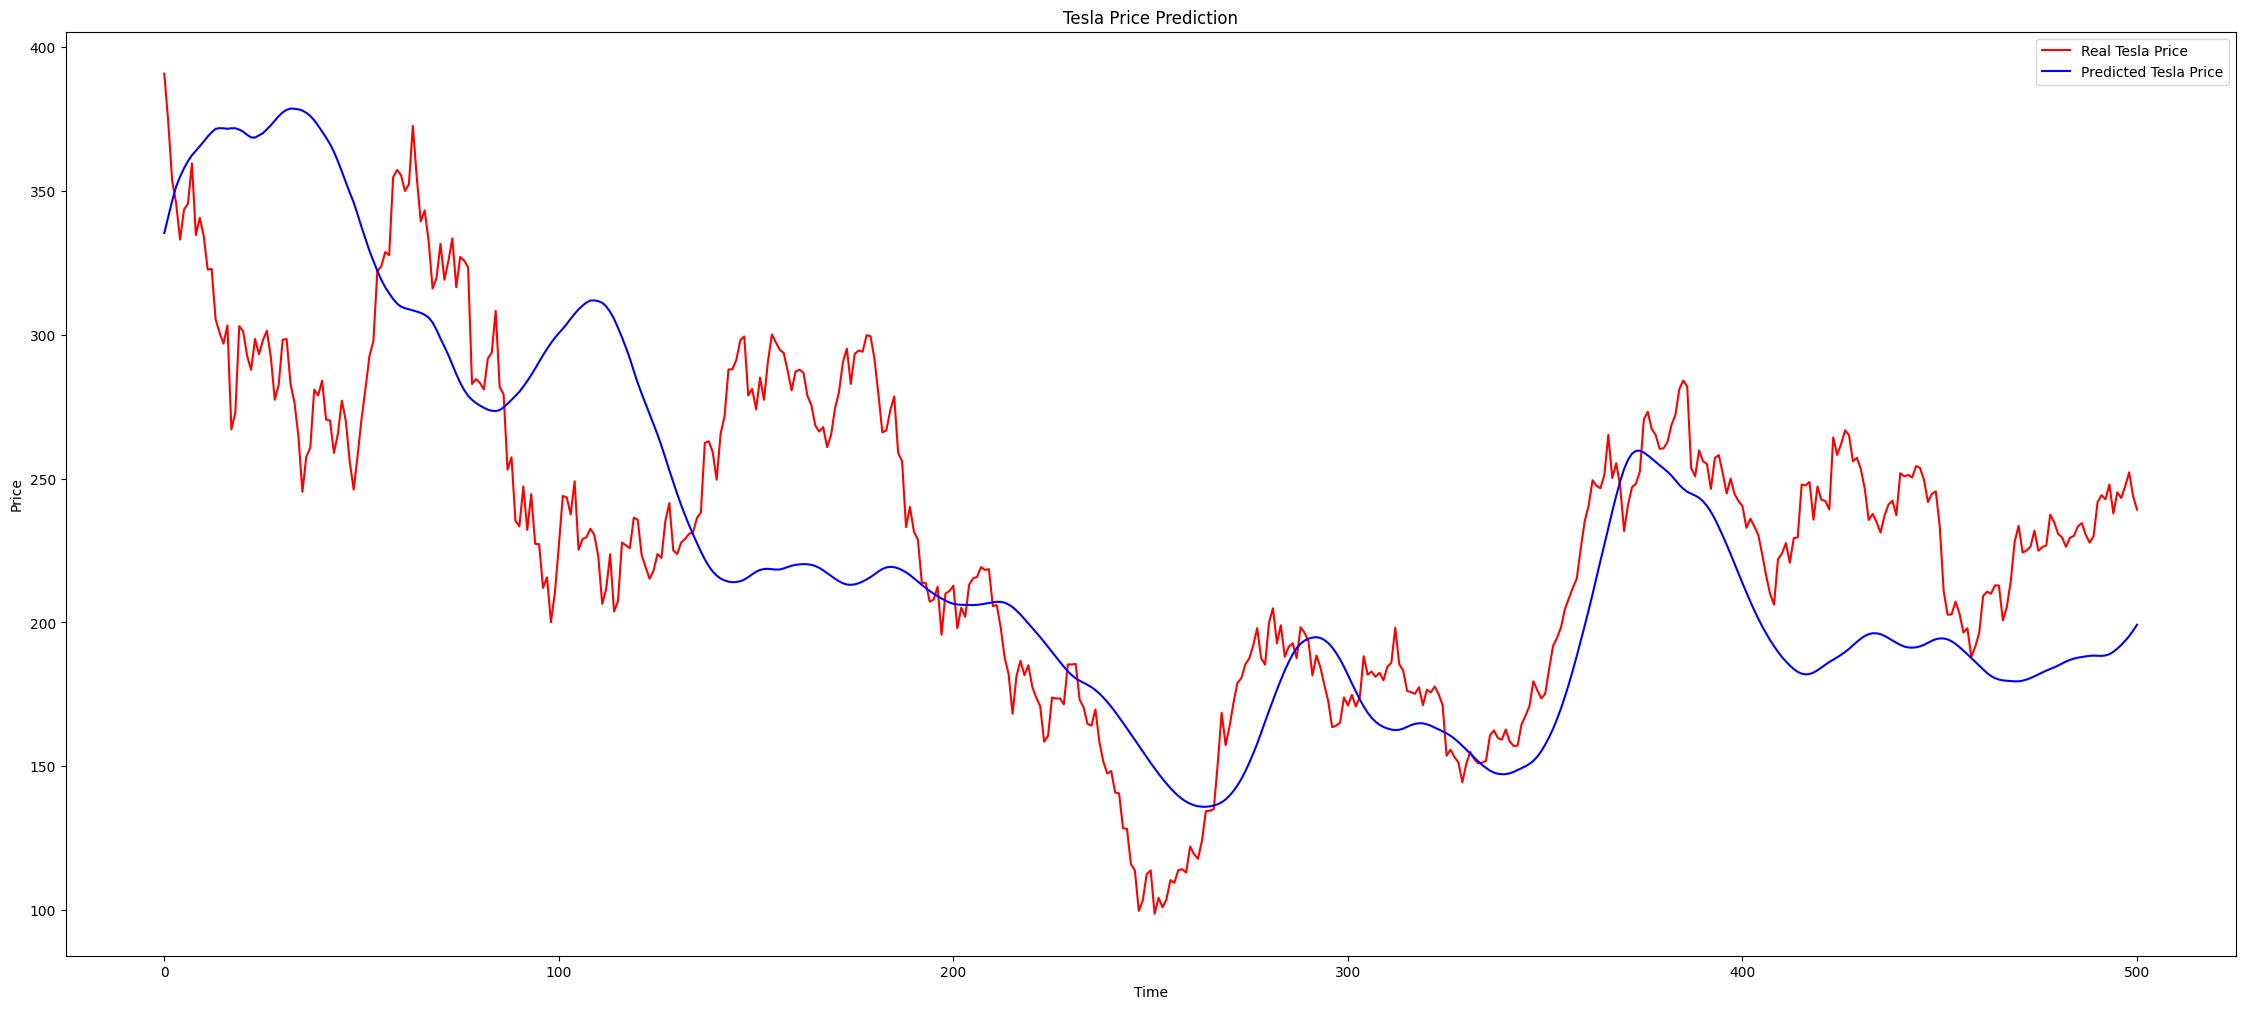

In [198]:
plt.figure(figsize=(28,12))
plt.plot(y_test, color = 'red', label = 'Real Tesla Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Tesla Price')
plt.title('Tesla Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [197]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

df_result = pd.DataFrame()
df_result['true']= y_test
df_result['predicted']= y_pred

print(df_result)
print(f"mse: {mse:.2f}")
print(f"mae: {mae:.2f}")
print(len(y_pred))



print(y_test[0:10])
# mse: 1122.20
# mae: 26.06

#mse 1451
#mae 31.42

#1232
#2810

y_true_binary = (df_result['predicted'].diff().fillna(0) > 0).astype(int)
y_pred_binary = (df_result['true'].diff().fillna(0) > 0).astype(int)

report  = classification_report(y_true_binary, y_pred_binary)
print(report)

           true   predicted
0    390.637333  335.282867
1    373.907322  340.935059
2    353.417332  346.497894
3    345.610661  351.433868
4    333.030674  354.889343
..          ...         ...
496  243.250660  192.174332
497  247.320652  193.631485
498  252.150669  195.230759
499  243.890660  197.140594
500  239.190663  199.198593

[501 rows x 2 columns]
mse: 2148.90
mae: 37.52
501
[390.637333 373.907322 353.417332 345.610661 333.030674 343.417332
 345.510655 359.450657 334.564    340.580662]
              precision    recall  f1-score   support

           0       0.62      0.51      0.56       297
           1       0.43      0.54      0.48       204

    accuracy                           0.52       501
   macro avg       0.52      0.52      0.52       501
weighted avg       0.54      0.52      0.53       501

